Prophet Modeling

-  Prophet is capable of handling missing data points and outliers, making it a robust tool for forecasting real-world data
- single regressor model typically refers to a model where you have only one predictor variable (regressor) to forecast the target variable (usually a time series)
- In the case of Prophet, the single regressor model means you have one additional input feature (regressor) to aid in forecasting the target time series data
- Prophet allows you to include additional regressor variables to improve the accuracy of your forecasts. These regressors can represent any relevant information that might impact the time series you are trying to predict. For example, if you are forecasting daily sales data, a regressor could be a binary variable indicating whether it's a holiday or not. Including such additional information can help Prophet make more accurate predictions.

- Additive Regressive Model
- y(t) = g(t) (trend factor) + h(t) (holiday component) + s(t) (seasonality component) + e

- Trend factor: logistic growth model or piecewise linear model

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# import data
df = pd.read_csv('df_post_eda.csv')
df.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,day_of_week,quarter,dayofyear,dayofmonth,weekofyear,season,holidays,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
0,2023-05-10,19,NE,5481710,152400,1647380,2905630,0,283379,303944.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,NaN
1,2023-05-10,19,LA,10282120,330500,3807980,5164550,0,221178,236516.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,55.8
2,2023-05-10,19,GA,28727475,869100,9763000,14773655,0,270569,288404.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,43.3
3,2023-05-10,19,WY,1281755,49300,490040,585605,0,221466,235691.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,44.3
4,2023-05-10,19,CO,17769135,501900,5402640,9029715,0,308560,327449.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,47.3


In [3]:
# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

In [4]:
# Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

In [6]:
df = pd.DataFrame(df)
df.reset_index(level=0, inplace=True)
df = df.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})
df.tail()

,ds,y
75,2023-04-12,50.951563
76,2023-04-19,51.012500
77,2023-04-26,51.034375
78,2023-05-03,51.064062
79,2023-05-10,51.076563


In [7]:
df.head()

,ds,y
0,2021-11-03,10.332812
1,2021-11-10,13.185937
2,2021-11-17,15.871875
3,2021-11-24,18.675000
4,2021-12-01,20.689062


## Initial Prophet

In [8]:
# Instantiating a new Prophet model
# Assuming linear regression
m = Prophet()
m.fit(df)

10:19:41 - cmdstanpy - INFO - Chain [1] start processing
10:19:41 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Extend DF into future - Weekly on wednesdays
future = m.make_future_dataframe(periods=52, freq='W-WED')
future.tail()

,ds
127,2024-04-10
128,2024-04-17
129,2024-04-24
130,2024-05-01
131,2024-05-08


In [10]:
# Assign future values a predicted value
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2024-04-10,52.786855,32.648203,73.482141
128,2024-04-17,52.821918,32.315314,74.074667
129,2024-04-24,52.856981,31.992254,74.838357
130,2024-05-01,52.892044,31.360841,75.817965
131,2024-05-08,52.927107,30.624121,76.237741


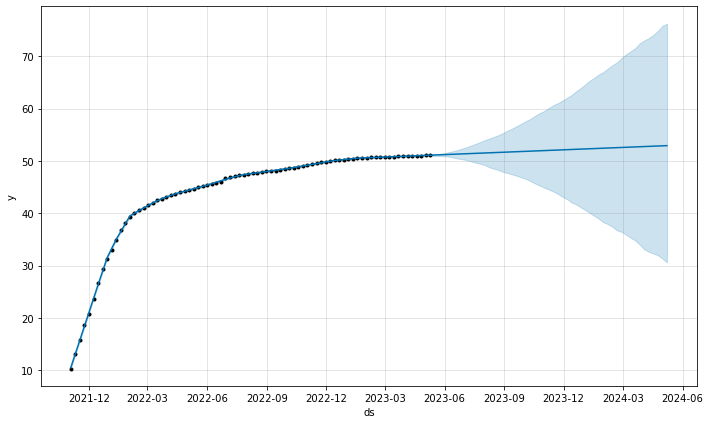

In [11]:
# Plot forecast
fig1 = m.plot(forecast)

## Max Capacity - Logistic Growth

In [30]:
# Need to set max capacity because of logistic regression
# set as 53 for now

df['cap'] = 53

In [31]:
m = Prophet(growth='logistic')
m.fit(df)

10:20:48 - cmdstanpy - INFO - Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing


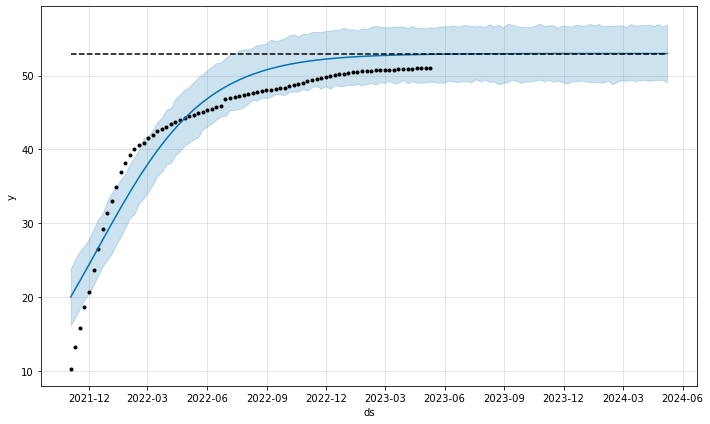

In [32]:
future = m.make_future_dataframe(periods=52, freq='W-WED')
future['cap'] = 53
fcst = m.predict(future)
fig = m.plot(fcst)

In [33]:
fcst.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
127,2024-04-10,52.998082,53,49.298485,56.898805,52.998082,52.998082,0.0,0.0,0.0,0.0,0.0,0.0,52.998082
128,2024-04-17,52.998238,53,49.385159,56.713846,52.998238,52.998238,0.0,0.0,0.0,0.0,0.0,0.0,52.998238
129,2024-04-24,52.998380,53,49.399642,56.983333,52.998380,52.998380,0.0,0.0,0.0,0.0,0.0,0.0,52.998380
130,2024-05-01,52.998512,53,49.441643,56.653015,52.998512,52.998512,0.0,0.0,0.0,0.0,0.0,0.0,52.998512
131,2024-05-08,52.998632,53,49.114579,56.911113,52.998632,52.998632,0.0,0.0,0.0,0.0,0.0,0.0,52.998632


In [34]:
# Initial RMSE

# Extract actual values and predicted values
actual_values = df['y']
predicted_values = fcst['yhat'][:-52] 

In [35]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.9593725179628465
